In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import joblib

In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [ ]:
print("Traning set shape", train_df.shape)
print("Testing set shape", test_df.shape)

Traning set shape (60000, 11)
Testing set shape (10000, 10)


In [ ]:
print(train_df.head())

   Atmospheric Density  Surface Temperature   Gravity  Water Content  \
0             0.472806                  NaN -0.313872      -2.089299   
1             4.180154            -1.157515  2.430956      -1.595850   
2            -0.129008             1.621592 -0.785741       2.081196   
3            -3.122000            -2.299818  1.072092       0.353524   
4            -1.459426             2.890268  0.148757      -0.804439   

   Mineral Abundance  Orbital Period  Proximity to Star  \
0          -0.152201       -0.885649           0.900105   
1          -3.188678       -0.609434          -0.199828   
2          -1.413796       -0.095152          -3.502577   
3          -0.192529        2.917067          -1.972329   
4           0.494875        0.044910          -0.438796   

  Magnetic Field Strength Radiation Levels  Atmospheric Composition Index  \
0                     NaN       Category_6                       0.692907   
1              Category_9       Category_9                

In [ ]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Atmospheric Density            57016 non-null  float64
 1   Surface Temperature            56968 non-null  float64
 2   Gravity                        57016 non-null  float64
 3   Water Content                  56923 non-null  float64
 4   Mineral Abundance              57079 non-null  float64
 5   Orbital Period                 57003 non-null  float64
 6   Proximity to Star              57055 non-null  float64
 7   Magnetic Field Strength        56942 non-null  object 
 8   Radiation Levels               56979 non-null  object 
 9   Atmospheric Composition Index  57058 non-null  float64
 10  Prediction                     56961 non-null  float64
dtypes: float64(9), object(2)
memory usage: 5.0+ MB
None


In [ ]:
print(train_df.describe())

       Atmospheric Density  Surface Temperature       Gravity  Water Content  \
count         57016.000000         56968.000000  57016.000000   56923.000000   
mean             -0.000202            -0.000288     -0.000469       0.001938   
std               2.263527             1.936598      1.804605       1.689267   
min              -4.364843            -5.503527     -5.553877      -5.816755   
25%              -1.555810            -1.426786     -1.279002      -1.218870   
50%              -0.188670            -0.330037      0.046231      -0.004676   
75%               1.308113             1.503646      1.255432       1.063391   
max               9.324018             5.638094      6.030290       6.287045   

       Mineral Abundance  Orbital Period  Proximity to Star  \
count       57079.000000    57003.000000       57055.000000   
mean           -0.000730       -0.001043           0.000188   
std             1.605524        1.511685           1.316682   
min            -5.077363   

In [ ]:
missing_values = train_df.isnull().sum()
print(missing_values)

Atmospheric Density              2984
Surface Temperature              3032
Gravity                          2984
Water Content                    3077
Mineral Abundance                2921
Orbital Period                   2997
Proximity to Star                2945
Magnetic Field Strength          3058
Radiation Levels                 3021
Atmospheric Composition Index    2942
Prediction                       3039
dtype: int64


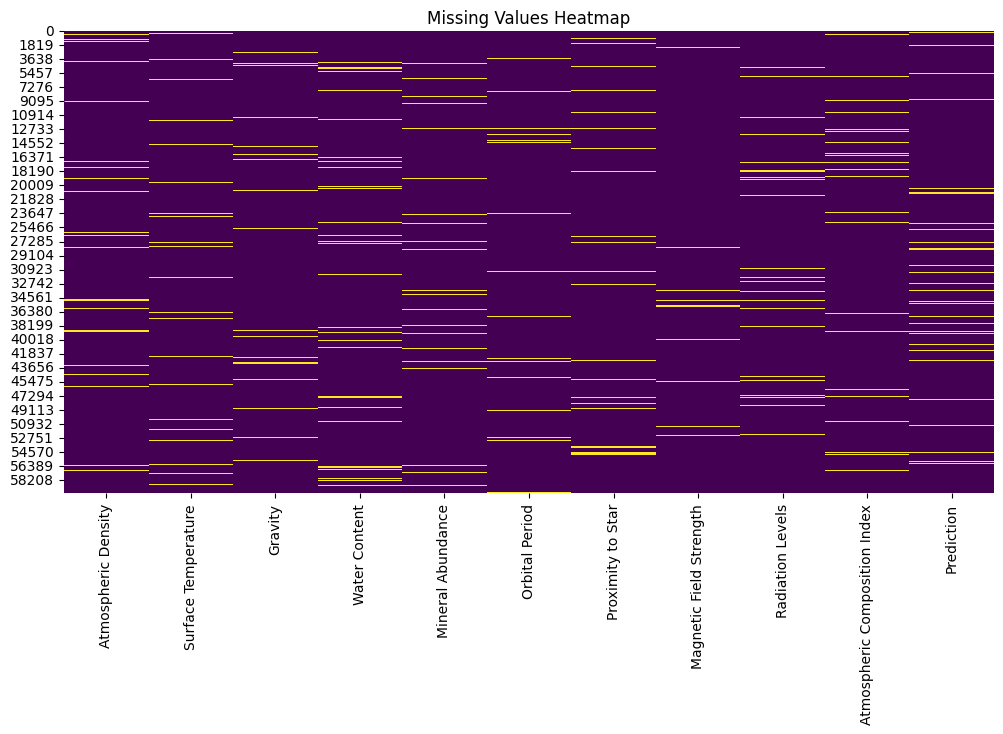

In [ ]:
plt.figure(figsize=(12, 6))
sns.heatmap(train_df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

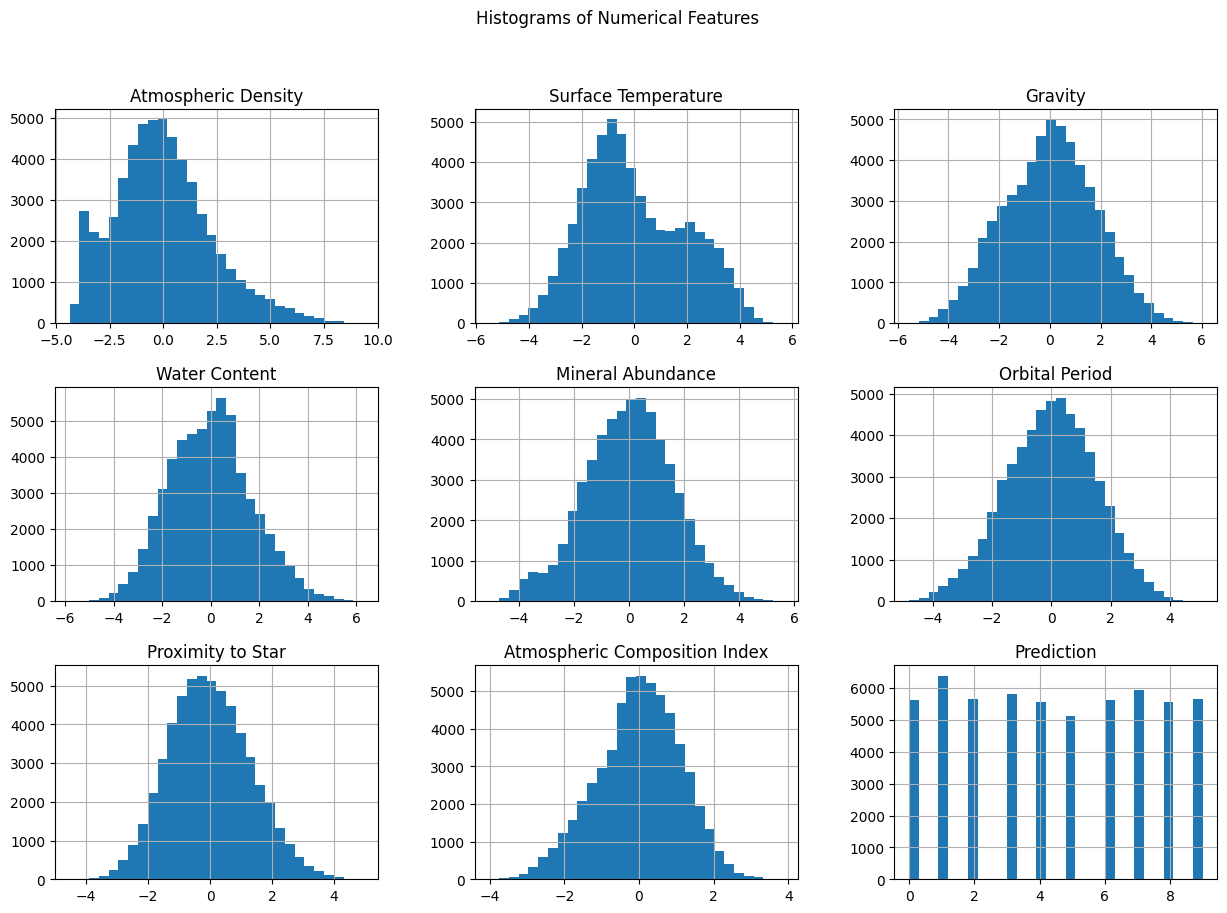

In [ ]:
numerical_features = train_df.select_dtypes(include=[np.number]).columns
train_df[numerical_features].hist(bins=30, figsize=(15, 10))
plt.suptitle('Histograms of Numerical Features')
plt.show()

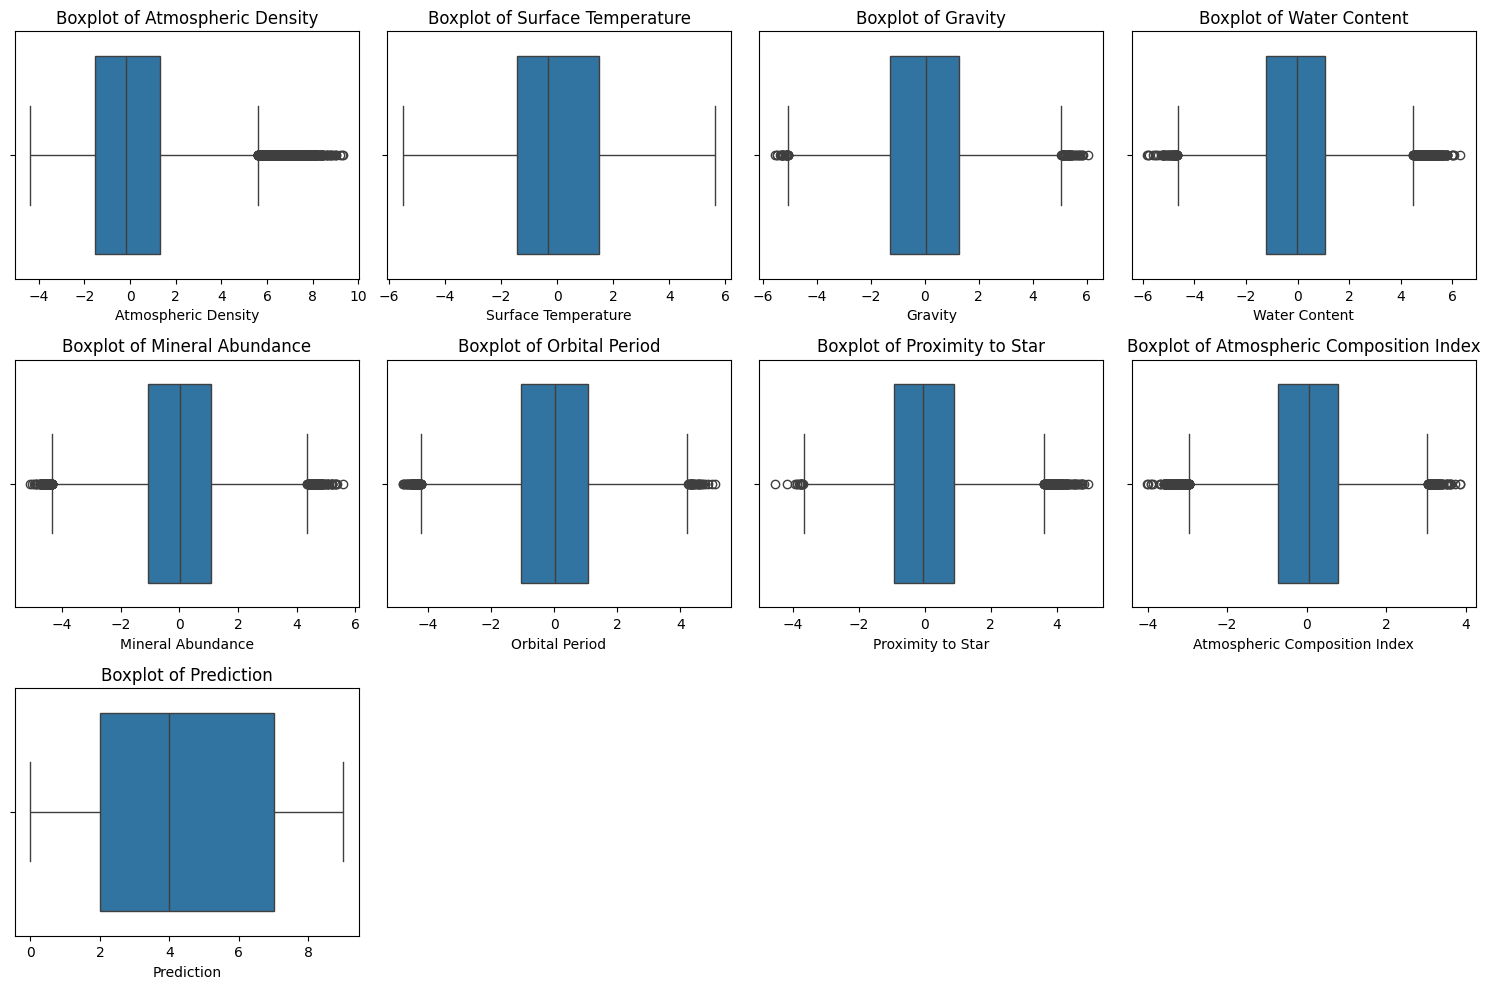

In [ ]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_features, 1):
  plt.subplot(3, 4, i)
  sns.boxplot(data=train_df, x=col)
  plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

In [ ]:
numeric_cols = train_df.select_dtypes(include=[np.number]).columns
cat_cols = train_df.select_dtypes(include=['object']).columns

In [ ]:
for col in cat_cols:
    if train_df[col].isnull().sum() > 0:
        mode_val = train_df[col].mode()[0]
        train_df[col].fillna(mode_val, inplace=True)

<ipython-input-13-a74338cc1772>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[col].fillna(mode_val, inplace=True)


In [ ]:
knn_imputer = KNNImputer(n_neighbors=5, weights='uniform')

In [ ]:
train_df[numeric_cols] = knn_imputer.fit_transform(train_df[numeric_cols])

In [ ]:
print(train_df.isnull().sum())

Atmospheric Density              0
Surface Temperature              0
Gravity                          0
Water Content                    0
Mineral Abundance                0
Orbital Period                   0
Proximity to Star                0
Magnetic Field Strength          0
Radiation Levels                 0
Atmospheric Composition Index    0
Prediction                       0
dtype: int64


In [ ]:
numeric_cols = train_df.select_dtypes(include=[np.number]).columns

In [ ]:

def cap_outliers(df, columns, lower_quantile=0.01, upper_quantile=0.99):
    for col in columns:
        # Calculate lower and upper thresholds
        lower_bound = df[col].quantile(lower_quantile)
        upper_bound = df[col].quantile(upper_quantile)

        # Clip the values in the column to these bounds
        df[col] = np.clip(df[col], lower_bound, upper_bound)

        print(f"{col}: Capped values below {lower_bound:.3f} and above {upper_bound:.3f}.")
    return df

In [ ]:
train_df = cap_outliers(train_df, numeric_cols)

Atmospheric Density: Capped values below -3.879 and above 6.262.
Surface Temperature: Capped values below -3.739 and above 4.140.
Gravity: Capped values below -3.993 and above 3.963.
Water Content: Capped values below -3.598 and above 4.079.
Mineral Abundance: Capped values below -3.865 and above 3.598.
Orbital Period: Capped values below -3.531 and above 3.282.
Proximity to Star: Capped values below -2.798 and above 3.171.
Atmospheric Composition Index: Capped values below -2.681 and above 2.348.
Prediction: Capped values below 0.000 and above 9.000.


In [ ]:
train_df['Prediction'] = train_df['Prediction'].astype(int)

target_col = 'Prediction'
feature_cols = [col for col in train_df.columns if col != target_col]

In [ ]:
numeric_cols = train_df[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = train_df[feature_cols].select_dtypes(include=['object']).columns.tolist()

In [ ]:
print("Numerical Columns:", numeric_cols)
print("Categorical Columns:", categorical_cols)

Numerical Columns: ['Atmospheric Density', 'Surface Temperature', 'Gravity', 'Water Content', 'Mineral Abundance', 'Orbital Period', 'Proximity to Star', 'Atmospheric Composition Index']
Categorical Columns: ['Magnetic Field Strength', 'Radiation Levels']


In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),   # Scale numeric features
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)  # One-hot encode categorical features
    ]
)

In [ ]:
preprocessing_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

In [ ]:
X = train_df[feature_cols]
y = train_df[target_col]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train_preprocessed = preprocessing_pipeline.fit_transform(X_train)
X_val_preprocessed = preprocessing_pipeline.transform(X_val)

In [ ]:
print("Transformed training data shape:", X_train_preprocessed.shape)
print("Transformed validation data shape:", X_val_preprocessed.shape)

Transformed training data shape: (48000, 47)
Transformed validation data shape: (12000, 47)


In [ ]:
X_test_preprocessed = preprocessing_pipeline.transform(test_df[feature_cols])

In [ ]:
# Logistic Regression (multinomial for multi-class)
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200, random_state=42)

# Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Gradient Boosting Classifier
gb_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Support Vector Machine
svm_clf = SVC(probability=True, random_state=42)

# XGBoost Classifier
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

In [ ]:
models = {
    'Logistic Regression': log_reg,
    'Random Forest': rf_clf,
    'Gradient Boosting': gb_clf,
    'SVM': svm_clf,
    'XGBoost': xgb_clf
}

model_scores = {}

for name, model in models.items():
    # Fit the model on the preprocessed training data
    model.fit(X_train_preprocessed, y_train)
    # Predict on the validation set
    y_pred = model.predict(X_val_preprocessed)
    # Calculate accuracy
    acc = accuracy_score(y_val, y_pred)
    model_scores[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression Accuracy: 0.7812
Random Forest Accuracy: 0.8729
Gradient Boosting Accuracy: 0.8427
SVM Accuracy: 0.8993


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:11:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.8828


In [ ]:
ensemble_model = VotingClassifier(
    estimators=[
        ('lr', log_reg),
        ('rf', rf_clf),
        ('gb', gb_clf),
        ('svm', svm_clf),
        ('xgb', xgb_clf)
    ],
    voting='soft'
)

# Train the ensemble
ensemble_model.fit(X_train_preprocessed, y_train)

# Evaluate ensemble on validation data
y_pred_ensemble = ensemble_model.predict(X_val_preprocessed)
ensemble_accuracy = accuracy_score(y_val, y_pred_ensemble)
print(f"Ensemble Model Accuracy: {ensemble_accuracy:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:02:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Ensemble Model Accuracy: 0.8841


In [ ]:
base_estimators = [
    ('lr', log_reg),
    ('rf', rf_clf),
    ('gb', gb_clf),
    ('svm', svm_clf),
    ('xgb', xgb_clf)
]

# Define the meta-estimator (final estimator)
meta_estimator = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200, random_state=42)

# Build the stacking classifier using the existing models and variables
stacking_clf = StackingClassifier(
    estimators=base_estimators,
    final_estimator=meta_estimator,
    cv=5,               # 5-fold cross-validation for out-of-fold predictions
    passthrough=False   # Set True if you want to include original features in meta-model training
)

# Fit the stacking classifier on the preprocessed training data
stacking_clf.fit(X_train_preprocessed, y_train)

# Predict on the validation set and evaluate accuracy
y_pred_stack = stacking_clf.predict(X_val_preprocessed)
stacking_accuracy = accuracy_score(y_val, y_pred_stack)
print(f"Stacking Ensemble Accuracy: {stacking_accuracy:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:59:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Lea

Stacking Ensemble Accuracy: 0.8982


In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Define base estimators (same as before)
base_estimators = [
    ('lr', log_reg),
    ('rf', rf_clf),
    ('gb', gb_clf),
    ('svm', svm_clf),
    ('xgb', xgb_clf)
]

# Define a new meta-estimator using SVM
meta_estimator_svm = SVC(probability=True, random_state=42)

# Build the stacking classifier with the SVM meta-estimator
stacking_clf_svm = StackingClassifier(
    estimators=base_estimators,
    final_estimator=meta_estimator_svm,
    cv=5,               # 5-fold cross-validation for out-of-fold predictions
    passthrough=False   # Change to True if you want to include original features in meta-model training
)

# Fit the stacking classifier on the preprocessed training data
stacking_clf_svm.fit(X_train_preprocessed, y_train)

# Predict on the validation set and evaluate accuracy
y_pred_stack_svm = stacking_clf_svm.predict(X_val_preprocessed)
stacking_accuracy_svm = accuracy_score(y_val, y_pred_stack_svm)
print(f"Stacking Ensemble with SVM Meta-Estimator Accuracy: {stacking_accuracy_svm:.4f}")


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:44:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Lea

Stacking Ensemble with SVM Meta-Estimator Accuracy: 0.9003


In [ ]:
target_col = 'Prediction'
feature_cols = [col for col in train_df.columns if col != target_col]

X_full = train_df[feature_cols]
y_full = train_df[target_col]

In [ ]:
X_full_preprocessed = preprocessing_pipeline.fit_transform(X_full)

In [ ]:
stacking_clf_svm.fit(X_full_preprocessed, y_full)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:36:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Lea

StackingClassifier(cv=5,
                   estimators=[('lr',
                                LogisticRegression(max_iter=200,
                                                   multi_class='multinomial',
                                                   random_state=42)),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('gb',
                                GradientBoostingClassifier(random_state=42)),
                               ('svm', SVC(probability=True, random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,...
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              objective='multi:softprob', ...))],
                   final_estimator=SVC(probability=True, random_state=42))

In [ ]:
y_full_pred = stacking_clf_svm.predict(X_full_preprocessed)
print("Full Training Accuracy:", accuracy_score(y_full, y_full_pred))

Full Training Accuracy: 0.9443833333333334


In [ ]:
X_test = test_df.copy()

X_test_preprocessed = preprocessing_pipeline.transform(X_test)

In [ ]:
if hasattr(X_full_preprocessed, "toarray"):
    X_full_preprocessed = X_full_preprocessed.toarray()
if hasattr(X_test_preprocessed, "toarray"):
    X_test_preprocessed = X_test_preprocessed.toarray()

In [ ]:
feature_names = preprocessing_pipeline.named_steps['preprocessor'].get_feature_names_out()

In [ ]:
X_full_df = pd.DataFrame(X_full_preprocessed, columns=feature_names)

X_test_df = pd.DataFrame(X_test_preprocessed, columns=feature_names[:X_test_preprocessed.shape[1]])

In [ ]:
X_test_df = X_test_df.reindex(columns=X_full_df.columns, fill_value=0)

X_test_preprocessed_aligned = X_test_df.values

In [ ]:
print("Aligned test preprocessed shape:", X_test_preprocessed_aligned.shape)

y_test_pred = stacking_clf_svm.predict(X_test_preprocessed_aligned)
print("Predictions on test set generated successfully.")

Aligned test preprocessed shape: (10000, 48)
Predictions on test set generated successfully.


In [ ]:
label_mapping = {
    0: 'Bewohnbar',
    1: 'Terraformierbar',
    2: 'Rohstoffreich',
    3: 'Wissenschaftlich',
    4: 'Gasriese',
    5: 'Wüstenplanet',
    6: 'Eiswelt',
    7: 'Toxischetmosphäre',
    8: 'Hohestrahlung',
    9: 'Toterahswelt'
}

y_test_pred_text = [label_mapping.get(label, label) for label in y_test_pred]

submission_df = pd.DataFrame({
    'Planet_ID': range(0, len(test_df)),
    'Predicted_Class': y_test_pred_text
})

print(submission_df.head())

   Planet_ID    Predicted_Class
0          0  Toxischetmosphäre
1          1      Rohstoffreich
2          2    Terraformierbar
3          3          Bewohnbar
4          4           Gasriese


In [ ]:
submission_df.to_csv('submission.csv', index=False)
print("Submission file 'submission.csv' created successfully.")

Submission file 'submission.csv' created successfully.
